In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
from pathlib import Path

## Write labels to disk for visualization

In [ ]:
src_dirs = [
            #Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/'),
            #Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/'),
            #Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_3_201_to_300-2020_07_21_02_23_59-coco-1.0/'),
            #Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/'),
            Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_5_401_to_500-2020_08_20_20_52_20-coco-1.0/')
            ]

label_corrections = [
    { 1 : 1,
      2 : 2,
      3 : 3,
      4 : 4,
      5 : 5
    },
    { 1 : 1,
      2 : 3,
      3 : 5,
      4 : 4,
      5 : 2
    },
    { 1 : 1,
      2 : 5,
      3 : 3,
      4 : 2,
      5 : 4
    },
    { 1 : 1,
      2 : 2,
      3 : 3,
      4 : 4,
      5 : 5
    }
]

save_path = Path('/mnt/sandbox/projects/noaa_adapt/data/annotation_display/')


cat_color_map_rgb = {
                    1 : (255,255,255), 
                    2 : (0, 0, 255),
                    3 : (200,200,200),
                    4 : (42, 150, 42),
                    5 : (200, 200, 255)
}


cat_color_map_bgr = {
                    1 : (255,255,255),
                    2 : (255, 0, 0),
                    3 : (200,200,200),
                    4 : (42, 150, 42),
                    5 : (255, 200, 200)    
}

video_frames = []

for src_dir, label_correction in zip(src_dirs, label_corrections):

    #task_block_1_001_to_099-220_07_07_23_36_21-coco-1.0/
    img_dir = src_dir.joinpath('images/')
    coco_file = src_dir.joinpath('annotations/instances_default.json')
    
    gt = COCO(coco_file)
    
    img_paths = sorted(list(img_dir.glob('*.jpg')))
    
    #img_path = np.random.choice(img_paths)
    
    label_counts = {i : 0 for i in range(0,6)}
    frame_id = 0
    for ii, img_path in enumerate(img_paths):
        
        print(img_path)
        print('{}'.format(frame_id))
        img = Image.open(img_path)

        filename= img_path.stem
        label_img = np.zeros(np.shape(img))
        label_id_img = np.zeros(np.shape(img)[:-1])
        img_id = [img['id'] for img in gt.imgs.values() if filename in img['file_name']][0]
        ann_ids = gt.getAnnIds(img_id)
        for ann_id in ann_ids:
            ann = gt.anns[ann_id]
            cat_id = ann['category_id']
            cat_id = label_correction[cat_id]
            cont = np.array([ [int(ann['segmentation'][0][i]), int(ann['segmentation'][0][i+1])] for i in range(0, len(ann['segmentation'][0]) -1, 2)])    
            label_img = cv2.drawContours(label_img, [cont], -1, color=cat_color_map_bgr[cat_id], thickness=cv2.FILLED)
            label_id_img = cv2.drawContours(label_id_img, [cont], -1, color=cat_id, thickness=cv2.FILLED)

        labels, counts = np.unique(label_id_img, return_counts=True)
        print(labels, counts)
        for label,count in zip(labels, counts):
            label_counts[int(label)] += count

        display_im = cv2.resize(np.array(img), (1080, 720))
        display_label_im = cv2.resize(np.array(label_img), (1080, 720), cv2.INTER_NEAREST)

        combined = np.concatenate([display_im, np.uint8(display_label_im)], axis=1)
        video_frames.append(combined)
        
        save_filename = str(save_path.joinpath('{}.png'.format(filename)))
        print(save_filename)
        cv2.imwrite(save_filename, np.uint8(combined))
        
        frame_id += 1

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00301.jpg
0
[0. 1. 3. 4.] [  230501 19211117  1320006  3238376]
/mnt/sandbox/projects/noaa_adapt/data/annotation_display/DSC00301.png
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00302.jpg
1
[0. 1. 3. 4.] [  169086 18647372  1337309  3846233]
/mnt/sandbox/projects/noaa_adapt/data/annotation_display/DSC00302.png
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00303.jpg
2
[0. 1. 3. 4.] [  212355 16407383  2066372  5313890]
/mnt/sandbox/projects/noaa_adapt/data/annotation_display/DSC00303.png
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00304.jpg
3
[0. 1. 2. 3. 4. 5.] [  239071 13480778  2298457   3

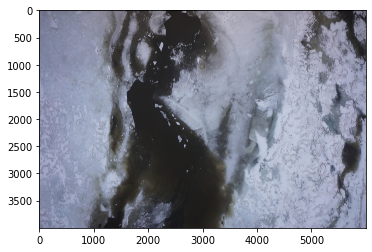

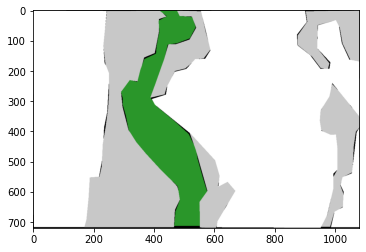

In [19]:
plt.imshow(img)
plt.figure()
plt.imshow(np.uint8(display_label_im))

In [30]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video=cv2.VideoWriter('/home/squadx/noaa_gt_video.avi', fourcc, 2, (2160,720))

for frame in video_frames:
    video.write(frame)

video.release()

In [6]:
frame.shape

(720, 2160, 3)

In [258]:
img_path = np.random.choice(img_paths)
#img_path = '/mnt/sandbox/projects/noaa_adapt/data/task_block_1_001_to_099-220_07_07_23_36_21-coco-1.0/images/DSC00074.jpg'
#img_path = '/mnt/sandbox/projects/noaa_adapt/data/task_block_1_001_to_099-220_07_07_23_36_21-coco-1.0/images/DSC00086.jpg'
#img_path = '/mnt/sandbox/projects/noaa_adapt/data/task_block_1_001_to_099-220_07_07_23_36_21-coco-1.0/images/DSC00055.jpg'
img = Image.open(img_path)

size = (3000,2000)

filename= img_path.stem
label_img = np.zeros(np.shape(img))
label_id_img = np.zeros(np.shape(img)[:-1])
img_id = [img['id'] for img in gt.imgs.values() if filename in img['file_name']][0]
ann_ids = gt.getAnnIds(img_id)
for ann_id in ann_ids:
    ann = gt.anns[ann_id]
    cat_id = ann['category_id']
    cont = np.array([ [int(ann['segmentation'][0][i]), int(ann['segmentation'][0][i+1])] for i in range(0, len(ann['segmentation'][0]) -1, 2)])    
    label_img = cv2.drawContours(label_img, [cont], -1, color=cat_color_map[cat_id], thickness=cv2.FILLED)
    label_id_img = cv2.drawContours(label_id_img, [cont], -1, color=cat_id, thickness=cv2.FILLED)

labels, counts = np.unique(label_id_img, return_counts=True)
print(labels, counts)
for label,count in zip(labels, counts):
    label_counts[int(label)] += count

display_im = cv2.resize(np.array(img), size)
display_label_im = cv2.resize(np.array(label_img), size, cv2.INTER_NEAREST)
    

[0. 1. 2. 3. 4. 5.] [ 236200 6525572 2379376  162433 8135958 6560461]


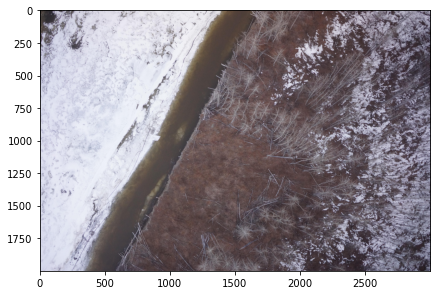

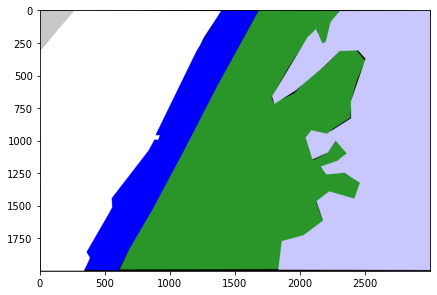

In [259]:
plt.figure(figsize=(7,5))
plt.imshow(display_im)
plt.figure(figsize=(7,5))
plt.imshow(np.uint8(display_label_im))

In [42]:
'''
label_counts = {0: 1239400690,
 1: 500540341,
 2: 70454374,
 3: 210450939,
 4: 289598181,
 5: 161555475}

label_counts = {
                 1: 435219264,
                 2: 60349668,
                 3: 181026161,
                 4: 148240072,
                 5: 136415120
                }
'''

label_counts = {1: 1944957670,
 2: 162608613,
 3: 768037393,
 4: 1204120403,
 5: 618680691
                }

downsample_rates = np.array(list(label_counts.values())) / np.min(list(label_counts.values()))

downsample_rates

array([11.96097571,  1.        ,  4.72322701,  7.40502229,  3.80472276])

## Write chips to disk

In [3]:
def mkdir_if_dne(path):
    if not os.path.exists(str(path)):
        os.mkdir(str(path))

export_chips= False
        
src_dirs = [
            'task1' : Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/'),
            'task2' : Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/'),
            'task3' : Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_3_201_to_300-2020_07_21_02_23_59-coco-1.0/'),
            'task4' : Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/'),
            'task5' : Path('/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_5_401_to_500-2020_08_20_20_52_20-coco-1.0/')
]

label_corrections = {
    'task1' : { 1 : 1,
              2 : 2,
              3 : 3,
              4 : 4,
              5 : 5
            },
    'task2' : { 1 : 1,
              2 : 3,
              3 : 5,
              4 : 4,
              5 : 2
            },
    'task3' : { 1 : 1,
              2 : 5,
              3 : 3,
              4 : 2,
              5 : 4
            },
    'task4' : { 1 : 1,
              2 : 5,
              3 : 3,
              4 : 2,
              5 : 4
            },
    'task5' : { 1 : 1,
              2 : 2,
              3 : 3,
              4 : 4,
              5 : 5
            }
}

# ice, water, ice/water, ground, snow

cat_color_map_rgb = {
                    1 : (255,255,255),
                    2 : (0, 0, 255),
                    3 : (200,200,200),
                    4 : (42, 150, 42),
                    5 : (200, 200, 255)
}

cat_color_map_bgr = {
                    1 : (255,255,255),
                    2 : (255, 0, 0),
                    3 : (200,200,200),
                    4 : (42, 150, 42),
                    5 : (255, 200, 200)    
}

label_counts = {i : 0 for i in range(1,6)}
label_counts[255] = 0

save_dir = Path('/mnt/sandbox/projects/noaa_adapt/data/chips_500sq/')

mkdir_if_dne(save_dir.joinpath('train'))
mkdir_if_dne(save_dir.joinpath('train/images'))
mkdir_if_dne(save_dir.joinpath('train/labels'))

mkdir_if_dne(save_dir.joinpath('val'))
mkdir_if_dne(save_dir.joinpath('val/images'))
mkdir_if_dne(save_dir.joinpath('val/labels'))

# Size to resize base (6000,4000) images to
size = (3000, 2000) # w, h

# Size of chips to extract 
window_size = 500
half_win = int(window_size / 2)

# Size of step for moving window through dataset
step_size = 250
split = .9
chip_id = 0

video_frames = {}

for task, src_dir in enumerate(src_dirs.items()):

    label_correction = label_corrections[task]
    
    img_dir = src_dir.joinpath('images/')
    coco_file = src_dir.joinpath('annotations/instances_default.json')

    gt = COCO(coco_file)

    labelled_images = np.unique([ann['image_id'] for ann in gt.anns.values()])

    img_paths = sorted(list(img_dir.glob('*.jpg')))
    
    #Skip first 5 frames of first video, which is over ground
    if task == 'task1':
        labelled_images = labelled_images[5:]

    for ii, image_id in enumerate(labelled_images):

        if ii < len(labelled_images)*split:
            mode = 'train'
        else:
            mode = 'val'

        img_path = img_paths[image_id]
        
        print(img_path)

        print('{}/{}'.format(ii, len(labelled_images)))

        # Load image
        img = Image.open(img_path)

        # Load label
        filename= img_path.stem
        label_img = np.zeros(np.shape(img))
        label_id_img = np.ones(np.shape(img)[:-1]) * 255
        img_id = [img['id'] for img in gt.imgs.values() if filename in img['file_name']][0]
        ann_ids = gt.getAnnIds(img_id)
        for ann_id in ann_ids:
            ann = gt.anns[ann_id]
            cat_id = ann['category_id']
            cat_id = label_correction[cat_id]
            cont = np.array([ [int(ann['segmentation'][0][i]), int(ann['segmentation'][0][i+1])] for i in range(0, len(ann['segmentation'][0]) -1, 2)])    
            label_img = cv2.drawContours(label_img, [cont], -1, color=cat_color_map_bgr[cat_id], thickness=cv2.FILLED)
            label_id_img = cv2.drawContours(label_id_img, [cont], -1, color=cat_id, thickness=cv2.FILLED)

        # Resize to train gsd
        img = cv2.resize(np.array(img), size)
        label_img = cv2.resize(np.array(label_img), size, interpolation=cv2.INTER_NEAREST)
        label_id_img = cv2.resize(np.array(label_id_img), size, interpolation=cv2.INTER_NEAREST)
        
        display_im = cv2.resize(np.array(img), (1080, 720))
        display_label_im = cv2.resize(np.array(label_img), (1080, 720), cv2.INTER_NEAREST)
       
        combined = np.concatenate([display_im, np.uint8(display_label_im)], axis=1)
        video_frames[filename] = combined
    
        #print(labels, counts)

        if export_chips:
            for rr in range(step_size, size[1], step_size):
                for cc in range(step_size, size[0], step_size):
                    img_chip = img[rr - half_win : rr + half_win, 
                                   cc - half_win : cc + half_win, 
                                   :]

                    label_id_img_chip = label_id_img[rr - half_win : rr + half_win, 
                                                     cc - half_win : cc + half_win, 
                                                     ]

                    labels, counts = np.unique(label_id_img_chip, return_counts=True)
                    for label,count in zip(labels, counts):
                        label_counts[int(label)] += count

                    img_save_path = '{}/{}/images/{}_{}.png'.format(save_dir, mode, filename, str(chip_id).zfill(6))
                    label_id_img_save_path = '{}/{}/labels/{}_{}.png'.format(save_dir, mode, filename, str(chip_id).zfill(6))
                    cv2.imwrite(img_save_path, img_chip)
                    cv2.imwrite(label_id_img_save_path, np.uint8(label_id_img_chip))

                    chip_id += 1



loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/images/DSC00055.jpg
0/45
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/images/DSC00056.jpg
1/45
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/images/DSC00057.jpg
2/45
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/images/DSC00058.jpg
3/45
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/images/DSC00059.jpg
4/45
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/images/DSC00060.jpg
5/45
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_1_001_to_099-2020_07_07_23_36_21-coco-1.0/images/DSC00061.jpg
6/45
/mnt/sandbox/projects

/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00118.jpg
18/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00119.jpg
19/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00120.jpg
20/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00121.jpg
21/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00122.jpg
22/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00123.jpg
23/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00124.jpg
24/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45

/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00182.jpg
82/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00183.jpg
83/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00184.jpg
84/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00185.jpg
85/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00186.jpg
86/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00187.jpg
87/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45_00-coco-1.0/images/DSC00188.jpg
88/101
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_2_100_to_200-2020_07_10_18_45

/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_3_201_to_300-2020_07_21_02_23_59-coco-1.0/images/DSC00245.jpg
44/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_3_201_to_300-2020_07_21_02_23_59-coco-1.0/images/DSC00246.jpg
45/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_3_201_to_300-2020_07_21_02_23_59-coco-1.0/images/DSC00247.jpg
46/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_3_201_to_300-2020_07_21_02_23_59-coco-1.0/images/DSC00248.jpg
47/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_3_201_to_300-2020_07_21_02_23_59-coco-1.0/images/DSC00249.jpg
48/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_3_201_to_300-2020_07_21_02_23_59-coco-1.0/images/DSC00250.jpg
49/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_3_201_to_300-2020_07_21_02_23_59-coco-1.0/images/DSC00251.jpg
50/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_3_201_to_300-2020_07_21_02_23

/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00308.jpg
7/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00309.jpg
8/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00310.jpg
9/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00311.jpg
10/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00312.jpg
11/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00313.jpg
12/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00314.jpg
13/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27

/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00372.jpg
71/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00373.jpg
72/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00374.jpg
73/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00375.jpg
74/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00376.jpg
75/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00377.jpg
76/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29_27-coco-1.0/images/DSC00378.jpg
77/100
/mnt/sandbox/projects/noaa_adapt/data/task_blocks/task_block_4_301_to_400-2020_08_01_02_29

In [4]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video=cv2.VideoWriter('/home/squadx/noaa_gt_video.avi', fourcc, 2, (2160,720))

for filename, frame in video_frames.items():
    video.write(frame)
    cv2.imwrite('/home/squadx/noaa_gt_frames/{}.png'.format(filename), frame)
video.release()

In [41]:
label_counts

{1: 1944957670,
 2: 162608613,
 3: 768037393,
 4: 1204120403,
 5: 618680691,
 255: 37095230}

In [12]:
im = cv2.imread('/mnt/sandbox/projects/noaa_adapt/data/airsim/train/labels/1598288716067_000455.png', cv2.IMREAD_UNCHANGED)

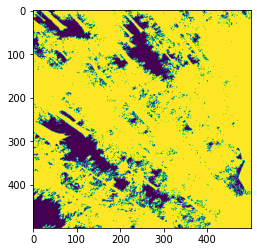

In [13]:
plt.imshow(im[:,:,0])

In [8]:
np.unique(im[:,:,0])

array([0, 2], dtype=uint8)